# this one does cross validation which shows the model is working with potential generalisable capabilities.

## we also do a permutation test to show the model is not just fitting noise.

## Interestingly this also works using only the top 3 features.


Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area
Fold 1 accuracy: 1.000 | balanced accuracy: 1.000
  True: [0 1 2] | Pred: [0 1 2]
Fold 2 

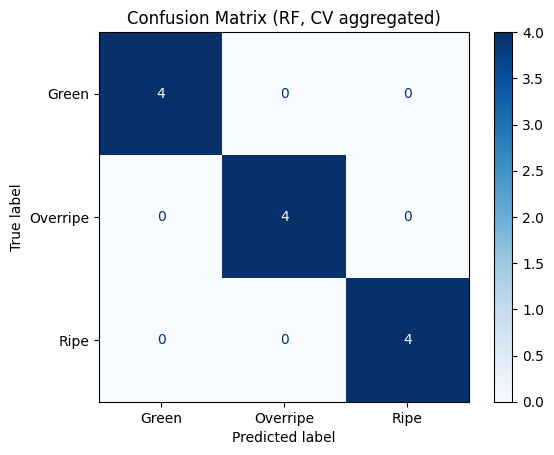

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_41436\1634325246.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")


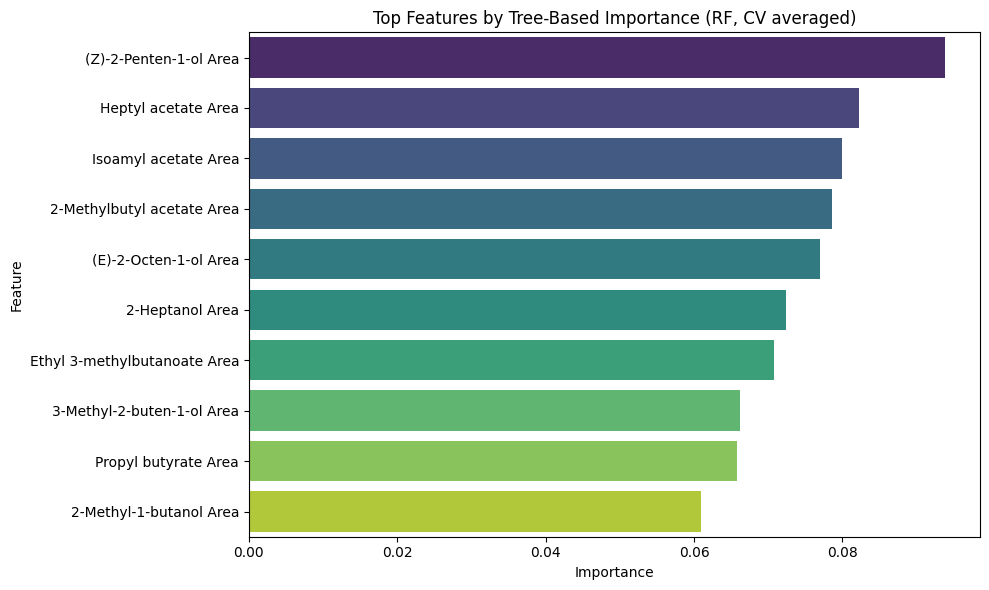

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_41436\1634325246.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = df.groupby("Groups")[top_features].mean().reset_index()


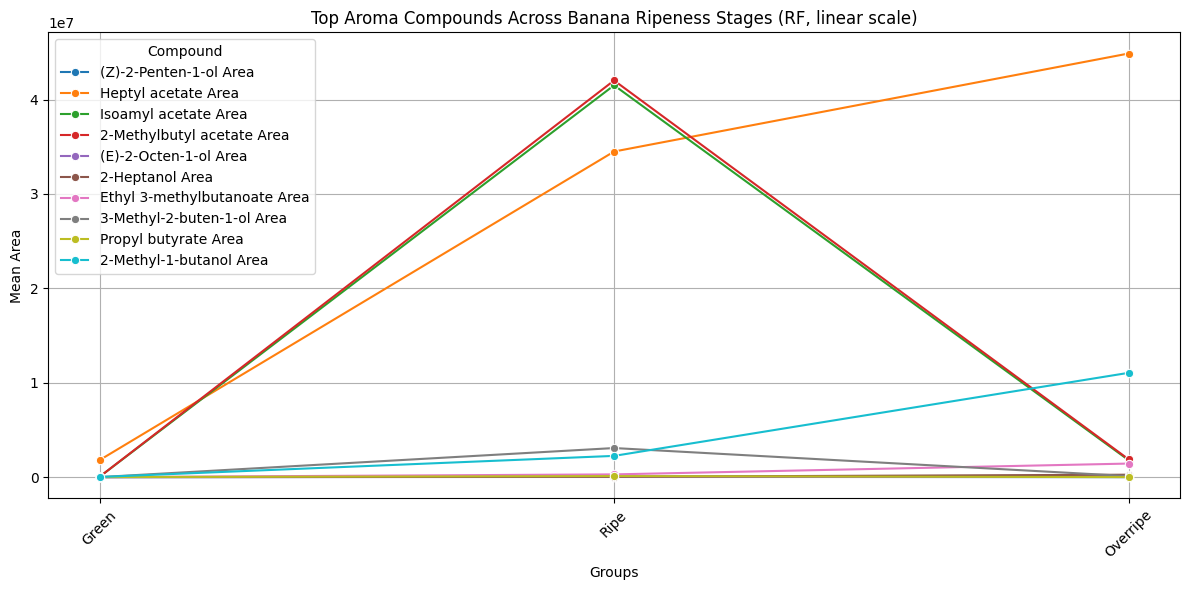

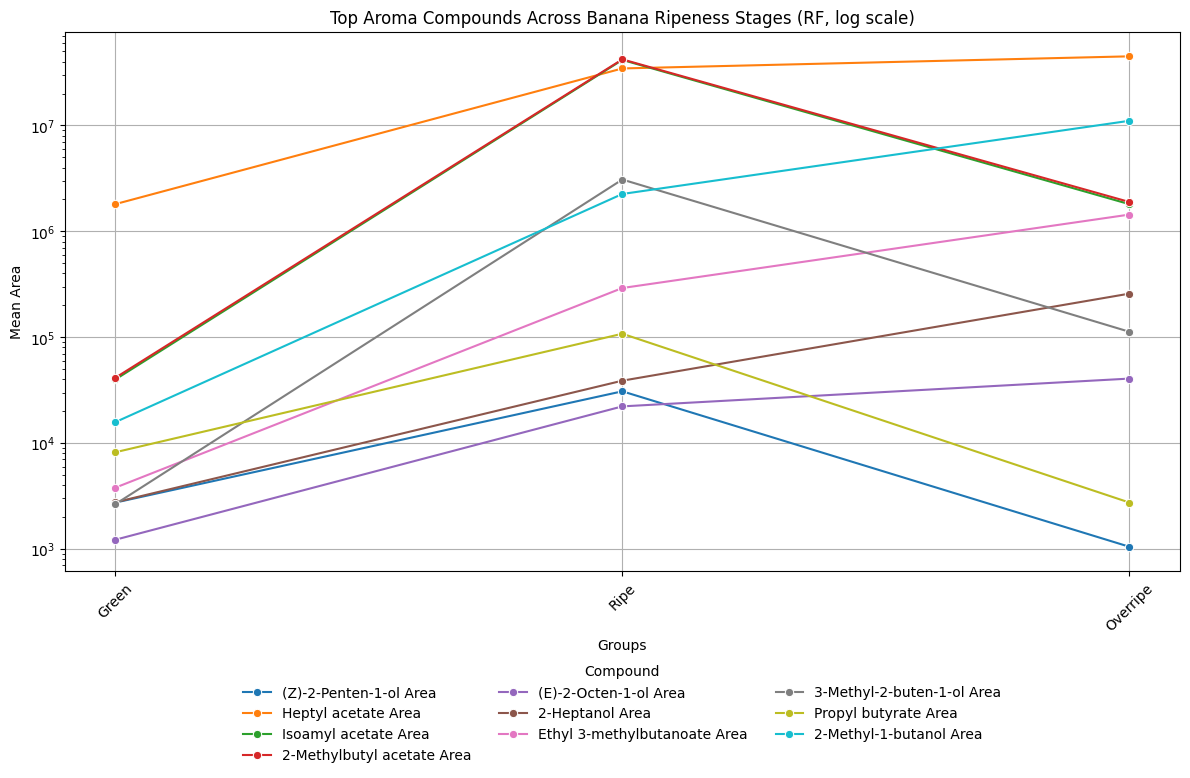


SHAP summary for class: Green


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from sklearn.manifold import TSNE
import umap.umap_ as umap

# ----------------------
# Step 1: Load and clean
# ----------------------
df = pd.read_csv("badata_imputed.csv")
df = df.drop(columns=[df.columns[0]])  # Drop index

# Separate labels(y) and features(X)
y_raw = df["Groups"]
X_raw = df.drop(columns=["Groups"])

# Identify and drop columns with any missing values
missing_cols = X_raw.columns[X_raw.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")

X = X_raw.drop(columns=missing_cols)

# Encode target classes and keep order
df["Groups"] = pd.Categorical(df["Groups"], categories=["Green", "Ripe", "Overripe"], ordered=True)
le = LabelEncoder()
y = le.fit_transform(y_raw)

# -----------------------------
# Step 2: Feature selection
# -----------------------------
k = min(15, X.shape[1])  # keep top 15 or fewer
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X_df = pd.DataFrame(X_selected, columns=selected_features)

# -----------------------------
# Step 3: Train Random Forest
# -----------------------------
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# ---------------------------------------------------
# Cross-validation (leave-one-out per condition)
# ---------------------------------------------------
n_splits = df["Groups"].value_counts().min()  # 4 (since 4 samples per class)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

scores = []
bal_scores = []
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(cv.split(X_df, y)):
    rf.fit(X_df.iloc[train_idx], y[train_idx])
    y_pred = rf.predict(X_df.iloc[test_idx])
    y_true = y[test_idx]

    all_true.extend(y_true)
    all_pred.extend(y_pred)

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    scores.append(acc)
    bal_scores.append(bal_acc)

    print(f"Fold {fold+1} accuracy: {acc:.3f} | balanced accuracy: {bal_acc:.3f}")
    print(f"  True: {y_true} | Pred: {y_pred}")

print(f"\nMean CV accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
print(f"Mean balanced accuracy: {np.mean(bal_scores):.3f} ± {np.std(bal_scores):.3f}")

# ---------------------------------------------------
# Confusion matrix (aggregated across folds)
# ---------------------------------------------------
cm = confusion_matrix(all_true, all_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (RF, CV aggregated)")
plt.show()

# -----------------------------
# Step 4: Feature Importance
# -----------------------------
rf.fit(X_df, y)
importances = rf.feature_importances_
importance_df = pd.DataFrame({"Feature": selected_features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top Features by Tree-Based Importance (RF, CV averaged)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Group means for plotting across conditions
# ---------------------------------------------------
top_features = importance_df.head(10)["Feature"].values
grouped_means = df.groupby("Groups")[top_features].mean().reset_index()

melted_df = grouped_means.melt(id_vars="Groups", var_name="Compound", value_name="Mean Area")
melted_df["Groups"] = pd.Categorical(melted_df["Groups"], categories=["Green", "Ripe", "Overripe"], ordered=True)

# Lineplot (linear scale)
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x="Groups", y="Mean Area", hue="Compound", marker="o")
plt.title("Top Aroma Compounds Across Banana Ripeness Stages (RF, linear scale)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Lineplot (log scale)
plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x="Groups", y="Mean Area", hue="Compound", marker="o")
plt.yscale("log")
plt.title("Top Aroma Compounds Across Banana Ripeness Stages (RF, log scale)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    title="Compound",
    frameon=False,
)
plt.tight_layout()
plt.show()

# -----------------------------
# Step 5: SHAP interpretation
# -----------------------------
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_df)

for class_idx, class_label in enumerate(le.classes_):
    print(f"\nSHAP summary for class: {class_label}")
    shap_class = shap_values[class_idx]  # correct slicing for RF
    shap.summary_plot(shap_class, X_df)

# -----------------------------
# Step 6: Permutation Importance (Robustness check)
# -----------------------------
perm_result = permutation_importance(rf, X_df, y, scoring="accuracy", n_repeats=10, random_state=42)
perm_df = pd.DataFrame(
    {
        "Feature": X_df.columns,
        "Importance": perm_result.importances_mean,
        "Std": perm_result.importances_std,
    }
).sort_values(by="Importance", ascending=False)

# Plot the distribution of importances across permutations for top 10 features
top_features_perm = importance_df.head(10)["Feature"].values
fig, ax = plt.subplots(figsize=(12, 6))
box_data = [perm_result.importances[i] for i in np.argsort(perm_result.importances_mean)[-10:][::-1]]
sns.boxplot(data=box_data)
ax.set_xticklabels(top_features_perm, rotation=45, ha="right")
ax.set_ylabel("Permutation Importance")
ax.set_title("Permutation Importance Distribution for Top 10 Features")
plt.tight_layout()
plt.show()

# -----------------------------
# Step 7: Final Metrics
# -----------------------------
y_pred = rf.predict(X_df)
print("\nClassification Report (on training data — use CV for generalization estimate):")
print(classification_report(y, y_pred, target_names=le.classes_))

# -----------------------------
# Step 8: t-SNE visualization
# -----------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
X_tsne = tsne.fit_transform(X_df)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=le.inverse_transform(y), palette="Set1", s=80)
plt.title("t-SNE plot of samples by selected features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Ripeness Group")
plt.tight_layout()
plt.show()

# -----------------------------
# Step 9: UMAP visualization
# -----------------------------
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.1)
X_umap = umap_model.fit_transform(X_df)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=le.inverse_transform(y), palette="Set1", s=80)
plt.title("UMAP plot of samples by selected features")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Ripeness Group")
plt.tight_layout()
plt.show()



Permutation test p-value: 0.0010
Observed accuracy: 1.000
Mean permuted accuracy: 0.400 ± 0.148


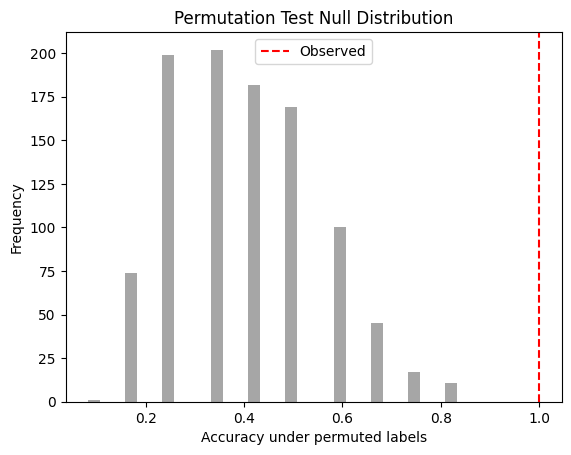

In [2]:
from sklearn.utils import shuffle

# ---------------------------------------------------
# Permutation test
# ---------------------------------------------------
n_permutations = 1000
perm_accuracies = []

for i in range(n_permutations):
    # shuffle labels
    y_perm = shuffle(y, random_state=i)

    # run CV with permuted labels
    perm_scores = []
    for train_idx, test_idx in cv.split(X_df, y_perm):
        rf.fit(X_df.iloc[train_idx], y_perm[train_idx])
        y_pred = rf.predict(X_df.iloc[test_idx])
        acc = accuracy_score(y_perm[test_idx], y_pred)
        perm_scores.append(acc)

    perm_accuracies.append(np.mean(perm_scores))

perm_accuracies = np.array(perm_accuracies)

# ---------------------------------------------------
# p-value calculation
# ---------------------------------------------------
observed_acc = np.mean(scores)  # from your real CV run
p_value = (np.sum(perm_accuracies >= observed_acc) + 1) / (n_permutations + 1)

print(f"\nPermutation test p-value: {p_value:.4f}")
print(f"Observed accuracy: {observed_acc:.3f}")
print(f"Mean permuted accuracy: {np.mean(perm_accuracies):.3f} ± {np.std(perm_accuracies):.3f}")

# ---------------------------------------------------
# Plot null distribution
# ---------------------------------------------------
plt.hist(perm_accuracies, bins=30, alpha=0.7, color="gray")
plt.axvline(observed_acc, color="red", linestyle="--", label="Observed")
plt.xlabel("Accuracy under permuted labels")
plt.ylabel("Frequency")
plt.title("Permutation Test Null Distribution")
plt.legend()
plt.show()


Fold 1 accuracy: 1.000 | balanced accuracy: 1.000
  True: [0 1 2] | Pred: [0 1 2]
Fold 2 accuracy: 1.000 | balanced accuracy: 1.000
  True: [0 1 2] | Pred: [0 1 2]
Fold 3 accuracy: 1.000 | balanced accuracy: 1.000
  True: [0 1 2] | Pred: [0 1 2]
Fold 4 accuracy: 1.000 | balanced accuracy: 1.000
  True: [0 1 2] | Pred: [0 1 2]

Mean CV accuracy: 1.000 ± 0.000
Mean balanced accuracy: 1.000 ± 0.000


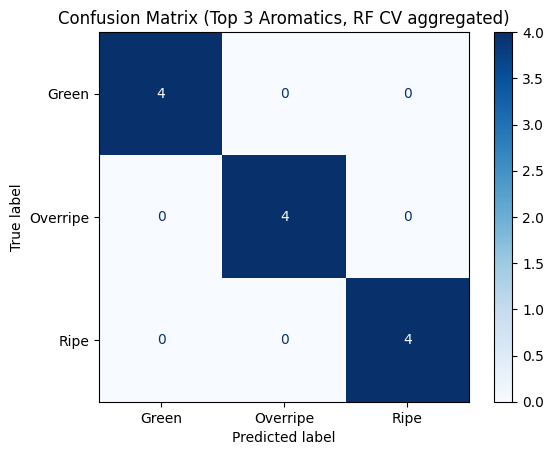

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# Select only top 3 features
# -----------------------------
top3_features = ["(Z)-2-Penten-1-ol Area", "Heptyl acetate Area", "Isoamyl acetate Area"]
X_top3 = df[top3_features]

# Encode labels
y = le.fit_transform(df["Groups"])

# Initialize Random Forest
rf_top3 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# ---------------------------------------------------
# Cross-validation (leave-one-out per condition)
# ---------------------------------------------------
n_splits = df["Groups"].value_counts().min()  # 4 samples per class
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

scores, bal_scores = [], []
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(cv.split(X_top3, y)):
    rf_top3.fit(X_top3.iloc[train_idx], y[train_idx])
    y_pred = rf_top3.predict(X_top3.iloc[test_idx])
    y_true = y[test_idx]

    all_true.extend(y_true)
    all_pred.extend(y_pred)

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    scores.append(acc)
    bal_scores.append(bal_acc)

    print(f"Fold {fold+1} accuracy: {acc:.3f} | balanced accuracy: {bal_acc:.3f}")
    print(f"  True: {y_true} | Pred: {y_pred}")

print(f"\nMean CV accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
print(f"Mean balanced accuracy: {np.mean(bal_scores):.3f} ± {np.std(bal_scores):.3f}")

# ---------------------------------------------------
# Confusion matrix (aggregated across folds)
# ---------------------------------------------------
cm = confusion_matrix(all_true, all_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Top 3 Aromatics, RF CV aggregated)")
plt.show()


C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_41436\1987640307.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = df.groupby('Groups')[top3_features].mean().reset_index()


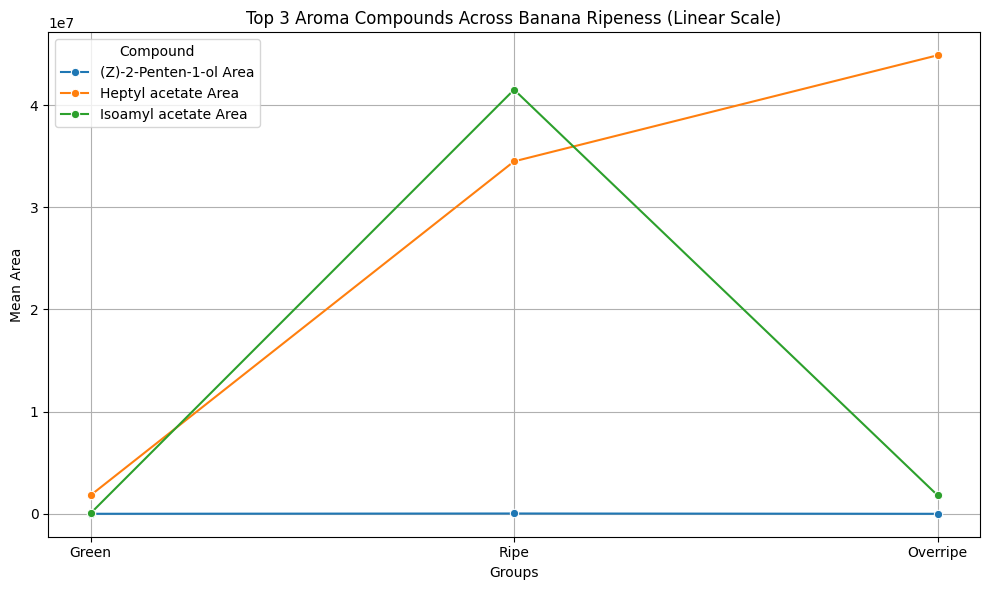

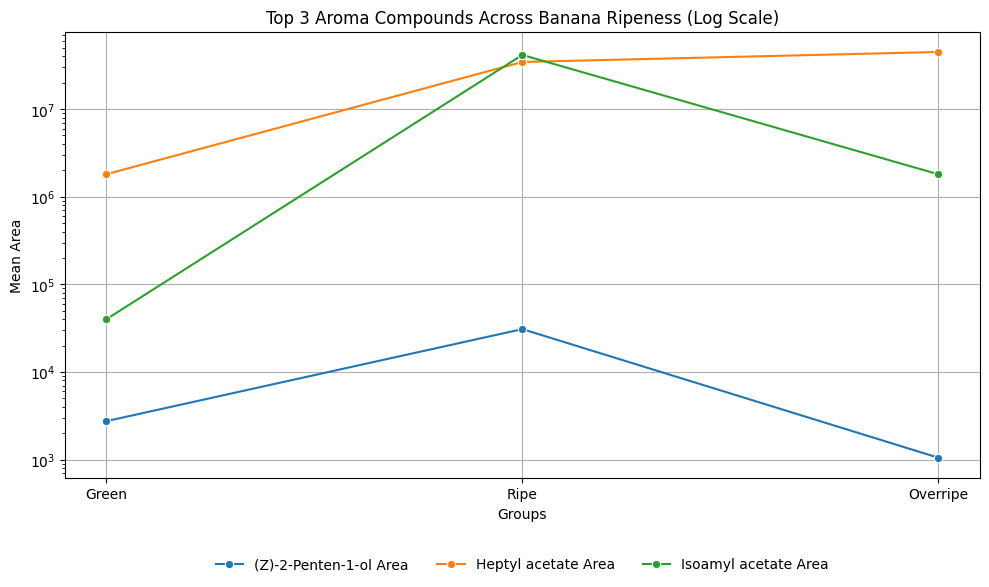

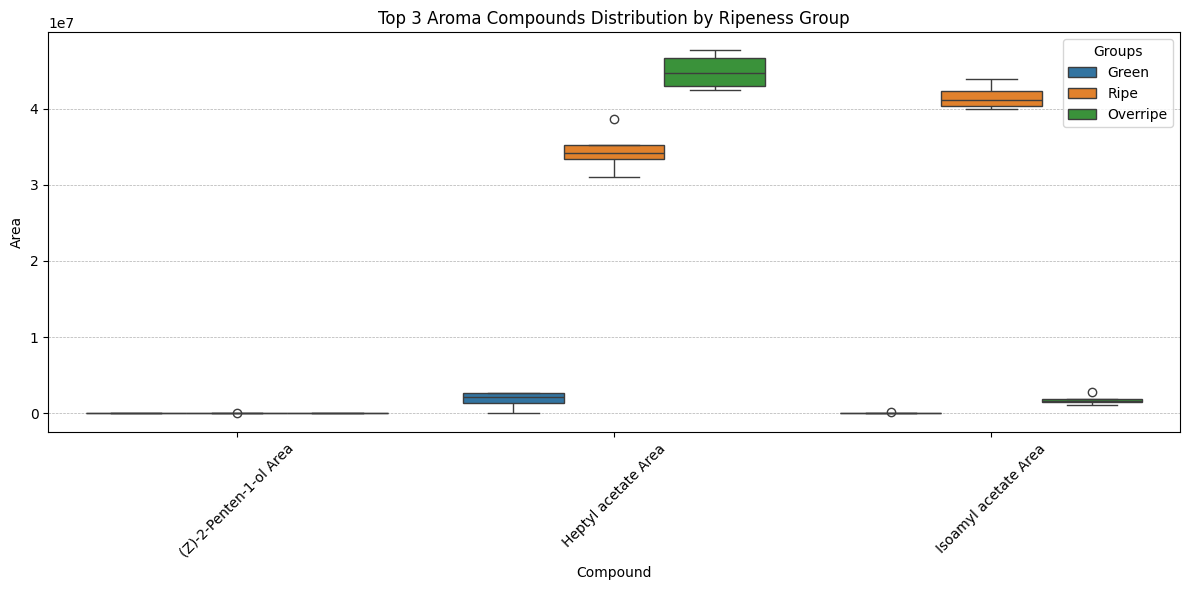

In [4]:
# -----------------------------
# Top 3 features for plotting
# -----------------------------
top3_features = ["(Z)-2-Penten-1-ol Area", "Heptyl acetate Area", "Isoamyl acetate Area"]

# Group means for lineplot
grouped_means = df.groupby('Groups')[top3_features].mean().reset_index()
melted_means = grouped_means.melt(id_vars='Groups', var_name='Compound', value_name='Mean Area')
melted_means['Groups'] = pd.Categorical(melted_means['Groups'], categories=['Green', 'Ripe', 'Overripe'], ordered=True)

# Lineplot (linear scale)
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_means, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.title("Top 3 Aroma Compounds Across Banana Ripeness (Linear Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Lineplot (log scale)
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_means, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.yscale('log')
plt.title("Top 3 Aroma Compounds Across Banana Ripeness (Log Scale)")
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.tight_layout()
plt.show()

# Boxplot (distribution per sample)
df_plot = df[['Groups'] + top3_features]
df_melted = df_plot.melt(id_vars='Groups', var_name='Compound', value_name='Area')
df_melted['Groups'] = pd.Categorical(df_melted['Groups'], categories=['Green', 'Ripe', 'Overripe'], ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Compound', y='Area', hue='Groups')
plt.title("Top 3 Aroma Compounds Distribution by Ripeness Group")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



SHAP summary for class: Green


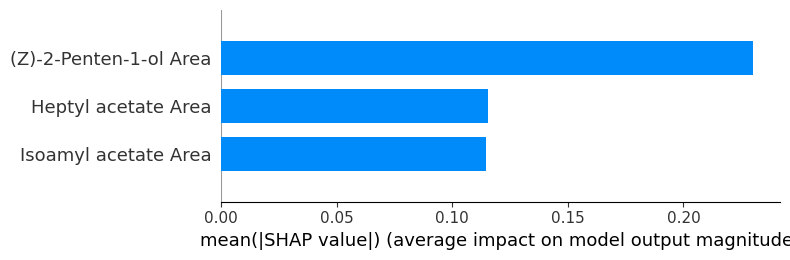


SHAP summary for class: Overripe


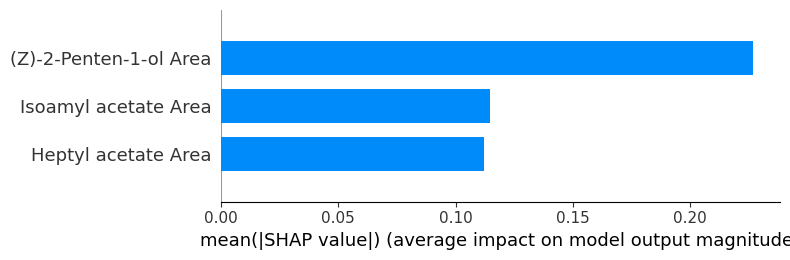


SHAP summary for class: Ripe


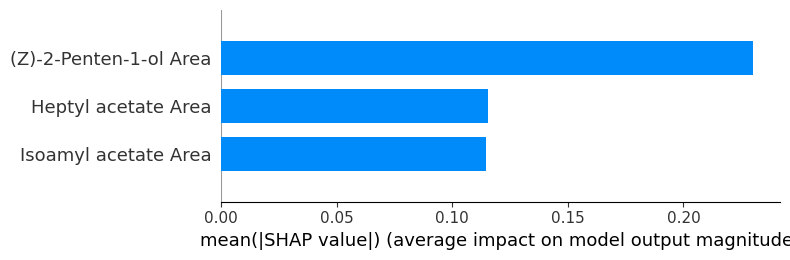

In [6]:
import shap

# -----------------------------
# SHAP interpretation for top 3 features
# -----------------------------
rf_top3 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_top3.fit(X_top3, y)

explainer = shap.TreeExplainer(rf_top3)
shap_values = explainer.shap_values(X_top3)

# Plot SHAP summary for each class
for class_idx, class_label in enumerate(le.classes_):
    print(f"\nSHAP summary for class: {class_label}")
    shap_class = shap_values[class_idx]  # shape = (n_samples, n_features)
    shap.summary_plot(shap_class, X_top3, feature_names=top3_features, plot_type="bar")



Permutation test p-value (top 3 features): 0.0010
Observed accuracy: 1.000
Mean permuted accuracy: 0.388 ± 0.144


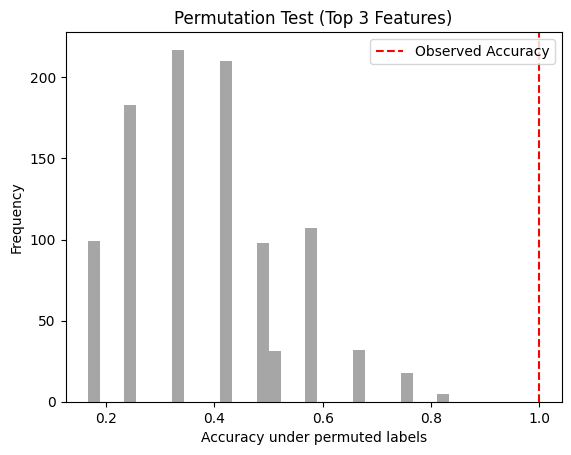

In [8]:
from sklearn.utils import shuffle

# -----------------------------
# Permutation test (top 3 features)
# -----------------------------
n_permutations = 1000
perm_accuracies_top3 = []

for i in range(n_permutations):
    # shuffle labels
    y_perm = shuffle(y, random_state=i)

    # run CV with permuted labels
    perm_scores = []
    for train_idx, test_idx in cv.split(X_top3, y_perm):
        rf_top3.fit(X_top3.iloc[train_idx], y_perm[train_idx])
        y_pred = rf_top3.predict(X_top3.iloc[test_idx])
        acc = accuracy_score(y_perm[test_idx], y_pred)
        perm_scores.append(acc)

    perm_accuracies_top3.append(np.mean(perm_scores))

perm_accuracies_top3 = np.array(perm_accuracies_top3)

# ---------------------------------------------------
# p-value calculation
# ---------------------------------------------------
observed_acc_top3 = np.mean(scores)  # mean CV accuracy from real top3 run
p_value_top3 = (np.sum(perm_accuracies_top3 >= observed_acc_top3) + 1) / (n_permutations + 1)

print(f"\nPermutation test p-value (top 3 features): {p_value_top3:.4f}")
print(f"Observed accuracy: {observed_acc_top3:.3f}")
print(f"Mean permuted accuracy: {np.mean(perm_accuracies_top3):.3f} ± {np.std(perm_accuracies_top3):.3f}")

# ---------------------------------------------------
# Plot null distribution
# ---------------------------------------------------
plt.hist(perm_accuracies_top3, bins=30, alpha=0.7, color="gray")
plt.axvline(observed_acc_top3, color="red", linestyle="--", label="Observed Accuracy")
plt.xlabel("Accuracy under permuted labels")
plt.ylabel("Frequency")
plt.title("Permutation Test (Top 3 Features)")
plt.legend()
plt.show()
